<a href="https://colab.research.google.com/github/Chizara69/rosee.github.io/blob/main/Asses_Time_series_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

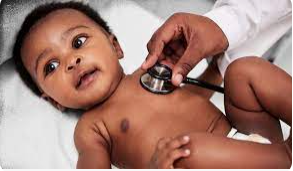

#Time series
# Heart rate prediction in babies

By: Roseline Ezeako


# According to the Review "Significance of Neonatal Heart Rate in the Delivery by MDPI (2023) the heart rate (HR) is the most significant indicator in newborns during perinatal transition. Any HR below 100 beats per minute (bpm), calls for intervention. AI is developing models with remarkable results

In this blog we will walk through the practical steps of building an effective time series model to predict the
next twenty 20 observations of heart rate dataset.

#Import Libraries

The process begins with importing the neccessary Libraries


In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          simport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from scipy.spatial.distance import cdist

# Load Data

In [ ]:
df = pd.read_csv("PT_Train.csv", parse_dates=["Timestamp (GMT)"])

In [ ]:
print(df.shape)

(226, 5)


#Basic EDA

In [ ]:
# Select 1st 5 rows of data
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139,41,NaN,NaN
1,2015-08-17 15:10:00,144,40,92.0,140.0
2,2015-08-17 15:11:00,140,42,89.0,144.0
3,2015-08-17 15:12:00,138,45,93.0,141.0
4,2015-08-17 15:13:00,133,42,94.0,134.0


In [ ]:
df.isnull().sum() # Checking for missing values - Non in Timestamp or Heart rate

Timestamp (GMT)                0
Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

In [ ]:
df.describe() # Lets look at some statistical measures

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


The range of Both the Heart rate & respiration rate are huge. Let's plot the features (Time & Heart rate) that we are interested in and take a closer look at distribution.

In [ ]:
# Features needed for prediction
df = df[["Timestamp (GMT)", "Lifetouch Heart Rate"]]

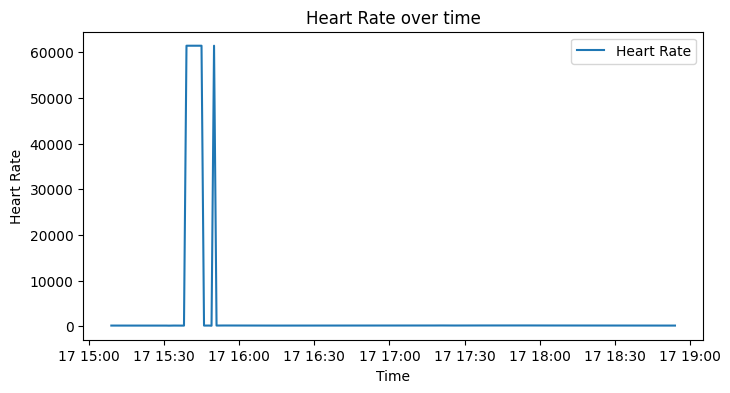

In [ ]:
# Lets plot the time series
plt.figure(figsize=(8,4))
plt.plot(df["Timestamp (GMT)"], df["Lifetouch Heart Rate"], label="Heart Rate")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Heart Rate over time")
plt.legend()
plt.show()

The above plot is showing some perculiar heart rates, they could be outliers. Lets see how many there are

#Data Wrangling

*   Identifying Ouliers & replacing
*   Making series Stationary  



In [ ]:
outliers = df[df["Lifetouch Heart Rate"] > 50000]
print(outliers)

       Timestamp (GMT)  Lifetouch Heart Rate
30 2015-08-17 15:39:00                 61441
31 2015-08-17 15:40:00                 61442
32 2015-08-17 15:41:00                 61441
33 2015-08-17 15:42:00                 61441
34 2015-08-17 15:43:00                 61441
35 2015-08-17 15:44:00                 61441
36 2015-08-17 15:45:00                 61442
41 2015-08-17 15:50:00                 61442


In [ ]:
# Coverting outliers to NaN values
df.loc[df["Lifetouch Heart Rate"] > 50000, "Lifetouch Heart Rate"] = pd.NA

In [ ]:
df.isnull().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    8
dtype: int64

 What shall we do with the outliers?? As its a time series lets not drop them but fill them with the forwardfill method. First we need to change te values to NaN values so they are values that can be filled.

In [ ]:
# We will fill the missing values with forward fill
df = df.fillna(df.ffill())
df.isnull().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    0
dtype: int64

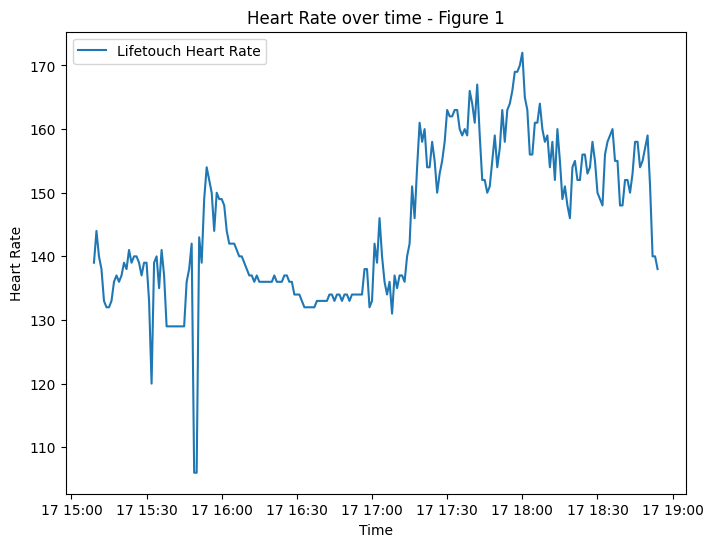

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(df['Timestamp (GMT)'], df['Lifetouch Heart Rate'], label='Lifetouch Heart Rate')
plt.ylabel("Heart Rate")
plt.xlabel("Time")
plt.title("Heart Rate over time - Figure 1")
plt.legend()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Timestamp (GMT)       226 non-null    datetime64[ns]
 1   Lifetouch Heart Rate  226 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


We can see from above that all outliers have been removed

In [ ]:
# Lets check if the series is Stationary
def check_stationarity(series):
  statistics, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f"p value:{p_value}")
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')
  #print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(df["Lifetouch Heart Rate"])

p value:0.01
Result: The series is not stationary 



<ipython-input-15-13d9e069f167>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistics, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


Whilst Figure 1 is useful in that it shows some pattern emerging in the last 2 hours of the series it is not stationary therefore cannot be used for forecasting
using traditional Time series models. Lets make the series stationary by removing any variation.

Log Transformation

In [ ]:
# Let's create a new column adding the log-transformed Heart Rate Values. This will bring the heart rate to a more common range.
df["Log Heart Rate"] = np.log(df['Lifetouch Heart Rate'])
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate
0,2015-08-17 15:09:00,139.0,4.934474
1,2015-08-17 15:10:00,144.0,4.969813
2,2015-08-17 15:11:00,140.0,4.941642
3,2015-08-17 15:12:00,138.0,4.927254
4,2015-08-17 15:13:00,133.0,4.890349


Lets see whether the Log transformation has made series stationary

In [ ]:
check_stationarity(df["Log Heart Rate"])

p value:0.01
Result: The series is not stationary 



<ipython-input-15-13d9e069f167>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistics, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


Deseasonalisation
lets remove the pattern (Seasonality) in the series

In [ ]:
df["Deseasonalised Heart Rate"] = df[["Log Heart Rate"]].diff(axis=0)


In [ ]:
df.head(250)

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate,Deseasonalised Heart Rate
0,2015-08-17 15:09:00,139.0,4.934474,NaN
1,2015-08-17 15:10:00,144.0,4.969813,0.035339
2,2015-08-17 15:11:00,140.0,4.941642,-0.028171
3,2015-08-17 15:12:00,138.0,4.927254,-0.014389
4,2015-08-17 15:13:00,133.0,4.890349,-0.036905
...,...,...,...,...
221,2015-08-17 18:50:00,159.0,5.068904,0.012658
222,2015-08-17 18:51:00,151.0,5.017280,-0.051624
223,2015-08-17 18:52:00,140.0,4.941642,-0.075637
224,2015-08-17 18:53:00,140.0,4.941642,0.000000


In [ ]:
df = df.drop(df.index[0])

In [ ]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Log Heart Rate,Deseasonalised Heart Rate
1,2015-08-17 15:10:00,144.0,4.969813,0.035339
2,2015-08-17 15:11:00,140.0,4.941642,-0.028171
3,2015-08-17 15:12:00,138.0,4.927254,-0.014389
4,2015-08-17 15:13:00,133.0,4.890349,-0.036905
5,2015-08-17 15:14:00,132.0,4.882802,-0.007547


In [ ]:
check_stationarity(df["Deseasonalised Heart Rate"])


p value:0.1
Result: The series is stationary 



<ipython-input-15-13d9e069f167>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistics, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


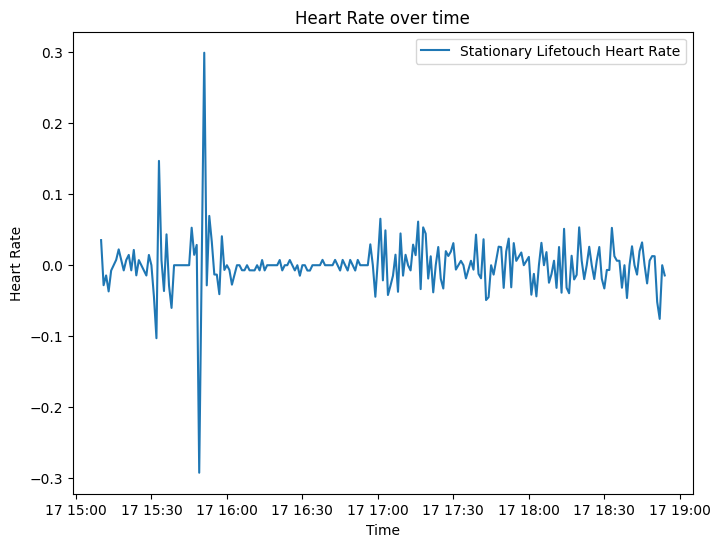

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(df['Timestamp (GMT)'], df['Deseasonalised Heart Rate'], label='Stationary Lifetouch Heart Rate')
plt.ylabel("Heart Rate")
plt.xlabel("Time")
plt.title("Heart Rate over time")
plt.legend()
plt.show()

Now that we have stationarity in the series we can proceed to Building our predictive model.

We have choosen to use the SARIMAX to build our predictive model.  Although the series is stationary the graphs still imply that there is a possibility of trend, SARIMAX will take this into consideration if so.

The model will use 90% of the data to predict and the remining 10% to evaluate.
Data split into testing (90%) and evaluation (10%)

In [ ]:
train_size = int(len(df) * 0.9)

train_series = df[:train_size]
eval_series = df[train_size:]

In [ ]:
#Lets look at the shape of the split
train_series.shape, eval_series.shape

((202, 4), (23, 4))

The training data range is from 15:09 to 18:31
The validation data range is from 18:32 to 18:54


In [ ]:
df.set_index('Timestamp (GMT)', inplace=True)
train_series.set_index('Timestamp (GMT)', inplace=True)
eval_series.set_index('Timestamp (GMT)', inplace=True)

# Forecasting

ARIMA Parameters

* p: Autoregressive order.
* d: Degree of differencing.
* q: Moving average order.

Lets generate a list with all possible combinations of p,d,q and use the best SARIMAX parameters along with the matching lowest Akaike Information Criterion (AIC).

In [ ]:
# Define the range of p, d, q, for SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_params = None


for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'], order=param,)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue
print(f'Best SARIMA parameters: {best_params} with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dat

Best SARIMA parameters: (2, 1, 2) with AIC: 1345.9031378433929


In [ ]:
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  225
Model:                 SARIMAX(2, 1, 2)   Log Likelihood                -667.952
Date:                  Wed, 13 Mar 2024   AIC                           1345.903
Time:                          18:05:45   BIC                           1362.961
Sample:                      08-17-2015   HQIC                          1352.789
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1593      0.166     -0.958      0.338      -0.485       0.167
ar.L2          0.2972      0.106      2.813      0.005       0.090       0.504
ma.L1          0.0246      0.139    

In [ ]:
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  225
Model:                 SARIMAX(2, 1, 2)   Log Likelihood                -667.952
Date:                  Wed, 13 Mar 2024   AIC                           1345.903
Time:                          18:05:45   BIC                           1362.961
Sample:                      08-17-2015   HQIC                          1352.789
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1593      0.166     -0.958      0.338      -0.485       0.167
ar.L2          0.2972      0.106      2.813      0.005       0.090       0.504
ma.L1          0.0246      0.139    

In [ ]:
#prediction
pred_start_date=eval_series.index[0]
pred_end_date=eval_series.index[-1]

In [ ]:
pred_start_date

Timestamp('2015-08-17 18:32:00')

In [ ]:
pred_end_date

Timestamp('2015-08-17 18:54:00')

In [ ]:
prediction = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
prediction

2015-08-17 18:32:00    150.169574
2015-08-17 18:33:00    149.408857
2015-08-17 18:34:00    156.029157
2015-08-17 18:35:00    155.738232
2015-08-17 18:36:00    158.208924
2015-08-17 18:37:00    158.019775
2015-08-17 18:38:00    154.831866
2015-08-17 18:39:00    155.519994
2015-08-17 18:40:00    148.818291
2015-08-17 18:41:00    150.884543
2015-08-17 18:42:00    151.932856
2015-08-17 18:43:00    152.450984
2015-08-17 18:44:00    150.213689
2015-08-17 18:45:00    153.621174
2015-08-17 18:46:00    156.355987
2015-08-17 18:47:00    156.623686
2015-08-17 18:48:00    153.482649
2015-08-17 18:49:00    155.428564
2015-08-17 18:50:00    156.011488
2015-08-17 18:51:00    158.307705
2015-08-17 18:52:00    150.707523
2015-08-17 18:53:00    143.955105
2015-08-17 18:54:00    143.731594
Freq: T, Name: predicted_mean, dtype: float64

In [ ]:
eval_series = eval_series.copy()  # Create a copy of eval_series to avoid the warning
eval_series.loc[:, 'Predicted_SARIMAX'] = prediction

In [ ]:
eval_series.head()

,Lifetouch Heart Rate,Log Heart Rate,Deseasonalised Heart Rate,Predicted_SARIMAX
Timestamp (GMT),,,,
2015-08-17 18:32:00,148.0,4.997212,-0.006734,150.169574
2015-08-17 18:33:00,156.0,5.049856,0.052644,149.408857
2015-08-17 18:34:00,158.0,5.062595,0.012739,156.029157
2015-08-17 18:35:00,159.0,5.068904,0.006309,155.738232
2015-08-17 18:36:00,160.0,5.075174,0.006270,158.208924


In [ ]:
mean_squared_error(eval_series['Lifetouch Heart Rate'], eval_series['Predicted_SARIMAX'])

17.664329245253214

<Axes: xlabel='Timestamp (GMT)'>

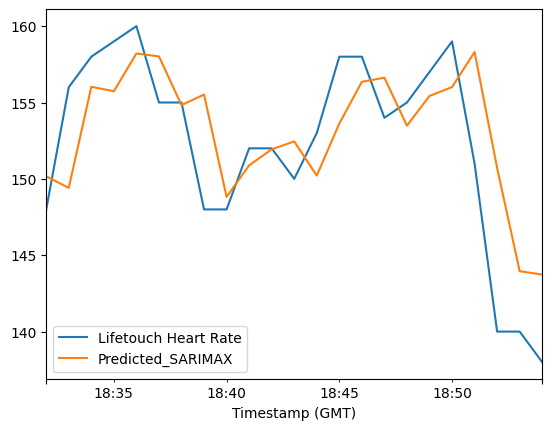

In [ ]:
eval_series[['Lifetouch Heart Rate', 'Predicted_SARIMAX']].plot()

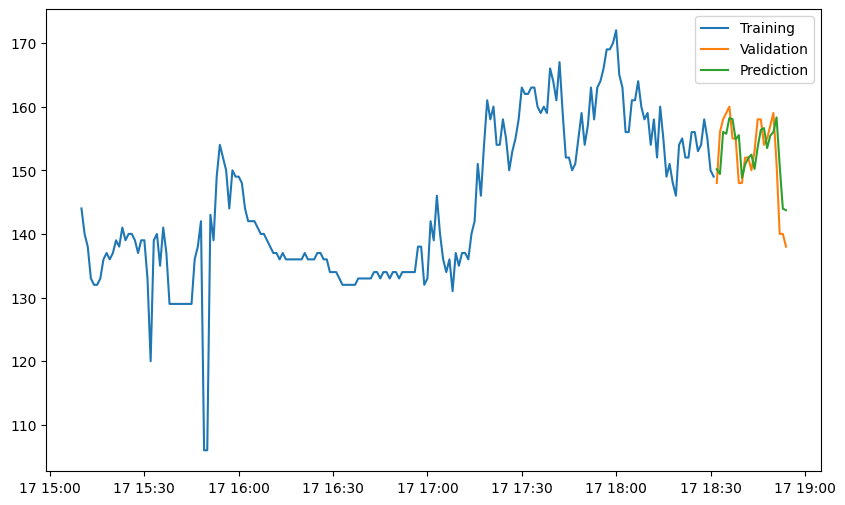

In [ ]:
# plot observations and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_series['Lifetouch Heart Rate'], label='Training')
plt.plot(eval_series['Lifetouch Heart Rate'], label='Validation')
plt.plot(eval_series['Predicted_SARIMAX'], label='Prediction')
plt.legend()
plt.show()

In [ ]:
forecasts = model_fit.get_forecast(steps=20)

In [ ]:
forecasts

In [ ]:
forecast_values = forecasts.predicted_mean

Lets go ahead and predict the Heart rate for the next 20 Mins from date stamp image.png

In [ ]:
forecast_values

2015-08-17 18:55:00    140.799311
2015-08-17 18:56:00    143.558599
2015-08-17 18:57:00    143.951087
2015-08-17 18:58:00    144.708620
2015-08-17 18:59:00    144.704619
2015-08-17 19:00:00    144.930390
2015-08-17 19:01:00    144.893244
2015-08-17 19:02:00    144.966257
2015-08-17 19:03:00    144.943590
2015-08-17 19:04:00    144.968899
2015-08-17 19:05:00    144.958131
2015-08-17 19:06:00    144.967368
2015-08-17 19:07:00    144.962697
2015-08-17 19:08:00    144.966186
2015-08-17 19:09:00    144.964242
2015-08-17 19:10:00    144.965589
2015-08-17 19:11:00    144.964796
2015-08-17 19:12:00    144.965323
2015-08-17 19:13:00    144.965003
2015-08-17 19:14:00    144.965211
Freq: T, Name: predicted_mean, dtype: float64

# Other experiments
A few other random combination of p,d,q were run just to cross check that the best combination was generated: see results below:-

| Model | p,d,q | Mean sq. Acc. |
|----------|----------|----------|
| 1 | 2,1,0 | 24.69 |
| 2 | 2,0,0 | 19.02|
| 3 | 1,0,2 | 18.95 |



#Conclusion
Due to the importance of accuracy in this prediction it would be suggested to explore the Lorenz Method which has proven to achieve very high accuracy scores.



In [ ]:
submission = pd.DataFrame({'prediction': forecast_values.values})

In [ ]:
submission.head()

,prediction
0,140.799311
1,143.558599
2,143.951087
3,144.708620
4,144.704619


In [ ]:
df = []
for index, row in submission.iterrows():
  df.append({'prediction': row['prediction']})

print(df[0:5])

[{'prediction': 140.79931137863582}, {'prediction': 143.55859946491927}, {'prediction': 143.95108703819417}, {'prediction': 144.70862018168148}, {'prediction': 144.70461889999572}]


In [ ]:
import json

submission_file_path = 'submission.json'
with open(submission_file_path, 'w') as fp:
  for i in df:
    fp.write(json.dumps(i) + '\n')